## LSTM Model 

LSTM stands for longer long short term memory networks and can be used for time series forecasting. It is a deep learning technique. 

###  Import Relevant Libraries and Data

In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

2024-09-12 21:56:54.403926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../data/preprocessed_stock_data.csv")
df.Date = pd.to_datetime(df.Date).dt.date
df.set_index('Date', inplace=True)
df.head()

,StockValue
Date,
2015-01-02,27.05
2015-01-09,26.36
2015-01-16,24.96
2015-01-23,25.64
2015-01-30,27.06


### Train Test Split 

In [3]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### Prepare Data for LSTM

Before a univariate series can be modeled, it must be prepared.

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

We will define a sequence function for that. 

In [4]:
def create_multiple_sequences(X, y, time_steps=1):
    """
    Works with single features(univariate) and multiple features
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
X_train, y_train = create_multiple_sequences(train, train.StockValue, 10)
X_test, y_test = create_multiple_sequences(test, test.StockValue, 10)
print(X_train.shape, y_train.shape)

(229, 10, 1) (229,)


In [6]:
# summarize the data
for i in range(len(X_train)):
 print(X_train[i], y_train[i])

[[27.05]
 [26.36]
 [24.96]
 [25.64]
 [27.06]
 [26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]] 28.57
[[26.36]
 [24.96]
 [25.64]
 [27.06]
 [26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]] 27.8
[[24.96]
 [25.64]
 [27.06]
 [26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]] 28.3
[[25.64]
 [27.06]
 [26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]] 28.01
[[27.06]
 [26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]] 26.92
[[26.71]
 [26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]
 [26.92]] 27.4
[[26.55]
 [27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]
 [26.92]
 [27.4 ]] 26.69
[[27.47]
 [26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]
 [26.92]
 [27.4 ]
 [26.69]] 28.62
[[26.95]
 [28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]
 [26.92]
 [27.4 ]
 [26.69]
 [28.62]] 27.55
[[28.34]
 [28.57]
 [27.8 ]
 [28.3 ]
 [28.01]
 [26.92]
 [27.4 ]
 [26.69]
 [28.62]
 [27.55]] 27.43
[[28.57]
 [27.8 ]
 [28.3 ]
 [28.0

### Fit the model 

#### 1. First Model with One Hidden Layer

In [7]:
#Define model
model = keras.Sequential()

#Model with 128 hidden units in layer

#First LSTM layer
model.add(keras.layers.LSTM(
          units=128,
          input_shape=(X_train.shape[1], X_train.shape[2])))

#Output layer
model.add(keras.layers.Dense(units=1))

#Compile the model 
model.compile( loss='mean_squared_error',optimizer=keras.optimizers.Adam(0.001))

2024-09-12 21:56:56.333121: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-09-12 21:56:56.617915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-12 21:56:56.619328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-12 21:56:56.6

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30


2024-09-12 21:56:56.726295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [206,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:56:56.726525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [206]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:56:56.974838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

12/13 [==========================>...] - ETA: 0s - loss: 1875.0365

2024-09-12 21:56:58.981209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [23]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:56:58.981557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [23]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 3s 65ms/step - loss: 1926.6954 - val_loss: 3072.1313
Epoch 2/30


2024-09-12 21:56:59.260129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-12 21:56:59.261975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-12 21:56:59.263436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 0s 27ms/step - loss: 1675.6127 - val_loss: 2757.3652
Epoch 3/30
13/13 [==============================] - 0s 22ms/step - loss: 1420.2443 - val_loss: 2406.8242
Epoch 4/30
13/13 [==============================] - 0s 21ms/step - loss: 1217.8577 - val_loss: 2144.1685
Epoch 5/30
13/13 [==============================] - 0s 25ms/step - loss: 1077.2977 - val_loss: 1960.2510
Epoch 6/30
13/13 [==============================] - 0s 23ms/step - loss: 947.4870 - val_loss: 1763.2794
Epoch 7/30
13/13 [==============================] - 0s 22ms/step - loss: 809.8050 - val_loss: 1555.6593
Epoch 8/30
13/13 [==============================] - 0s 19ms/step - loss: 682.5174 - val_loss: 1377.4603
Epoch 9/30
13/13 [==============================] - 0s 22ms/step - loss: 584.8416 - val_loss: 1235.9901
Epoch 10/30
13/13 [==============================] - 0s 22ms/step - loss: 500.3965 - val_loss: 1096.4515
Epoch 11/30
13/13 [==============================] - 0s 21ms/step - lo

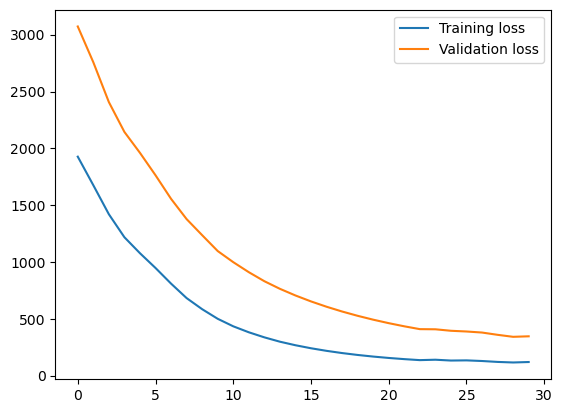

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

#### Prediction 

In [10]:
y_pred = model.predict(X_test)

2024-09-12 21:57:08.420073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:57:08.420875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 0s 7ms/step


2024-09-12 21:57:08.684190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-12 21:57:08.686229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-12 21:57:08.688133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

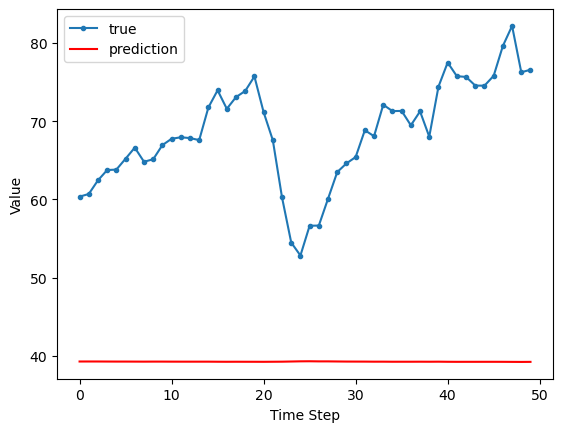

In [11]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [12]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {np.round(r2,2)}')

R-squared: -20.01


The model prediction is not very accurate with just one hidden layer.

#### 2. First Model with Two Hidden Layers

In [13]:
#Define model
model2 = keras.Sequential()

#Model with 128 hidden units in layer

#First LSTM layer
model2.add(keras.layers.LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

#Second LSTM Layer
model2.add(keras.layers.LSTM(units=128, activation='relu'))

#Output layer 
model2.add(keras.layers.Dense(units=1))

#Compile the model 
model2.compile( loss='mean_squared_error',optimizer=keras.optimizers.Adam(0.001))

In [14]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10, 128)           66560     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [15]:
history2 = model2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30


2024-09-12 21:57:09.312477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [206,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:57:09.312718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [206]
	 [[{{node Placeholder/_11}}]]


11/13 [========================>.....] - ETA: 0s - loss: 129.4417

2024-09-12 21:57:11.629398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [23]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:57:11.629796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [23]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 3s 67ms/step - loss: 112.4777 - val_loss: 12.9954
Epoch 2/30
13/13 [==============================] - 0s 37ms/step - loss: 12.5072 - val_loss: 16.5525
Epoch 3/30
13/13 [==============================] - 1s 42ms/step - loss: 8.3446 - val_loss: 17.4292
Epoch 4/30
13/13 [==============================] - 0s 34ms/step - loss: 6.6438 - val_loss: 27.1607
Epoch 5/30
13/13 [==============================] - 0s 29ms/step - loss: 9.4405 - val_loss: 14.8969
Epoch 6/30
13/13 [==============================] - 0s 30ms/step - loss: 11.1095 - val_loss: 41.5689
Epoch 7/30
13/13 [==============================] - 0s 29ms/step - loss: 8.3111 - val_loss: 14.3624
Epoch 8/30
13/13 [==============================] - 0s 32ms/step - loss: 25.0693 - val_loss: 33.6365
Epoch 9/30
13/13 [==============================] - 0s 28ms/step - loss: 10.6200 - val_loss: 24.6404
Epoch 10/30
13/13 [==============================] - 0s 30ms/step - loss: 15.2373 - val_loss: 14.4464
Epo

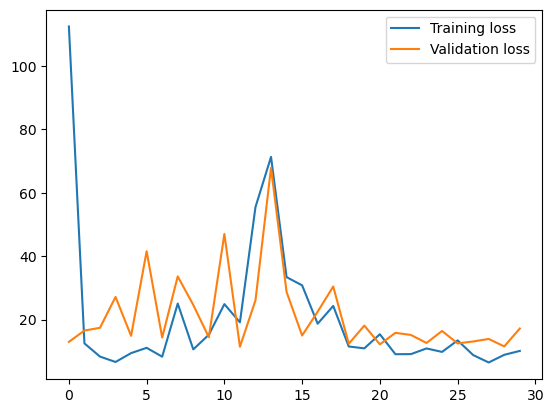

In [16]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend();

#### Prediction

In [17]:
y_pred = model2.predict(X_test)

2024-09-12 21:57:25.654198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:57:25.654471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 0s 15ms/step


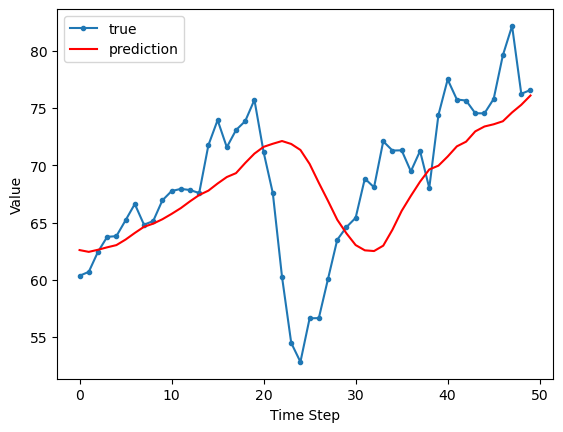

In [18]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [19]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {np.round(r2,2)}')

R-squared: 0.18


With two hidden layers we are getting a much more interesting result. Let's do some more fine tuning and check if we can get an even better result.

#### 3.  Fine tuning with higher number of epochs, learning rate scheduler and early stopping

**Why increase number of epochs?**
The model may need more time to learn complex patterns in the data, especially for deep neural networks like LSTM models that have many parameters to adjust. By increasing the number of epochs, the model gets more opportunities to improve its weights and reduce the training loss.

**Why Use a Learning Rate Scheduler?**
The learning rate controls the step size during gradient descent. If it's too high, the model may fail to converge or oscillate around a suboptimal solution. If it's too low, the training process may become very slow or get stuck in a local minimum. Using a scheduler allows the learning rate to start high, enabling fast learning in the beginning, and then decrease as training progresses to fine-tune the model.

**Why use Early Stopping?**
Early Stopping is a regularization technique that stops the training process when the model’s performance on a validation set stops improving. This helps avoid overfitting, which happens when the model performs well on the training data but poorly on unseen data (e.g., validation or test sets).

In [20]:
# Define model
model3 = keras.Sequential()

# First LSTM layer with return_sequences for stacking
model3.add(keras.layers.LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Second LSTM layer
model3.add(keras.layers.LSTM(units=128, activation='relu'))

# Output layer
model3.add(keras.layers.Dense(units=1))

# Compile the model with a lower learning rate and L2 regularization
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='mean_squared_error', optimizer=optimizer)

# Early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100


2024-09-12 21:57:26.388590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [229]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:57:26.388871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [229]
	 [[{{node Placeholder/_11}}]]


15/15 [==============================] - ETA: 0s - loss: 232.0892

2024-09-12 21:57:28.932083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [50]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:57:28.935078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [50]
	 [[{{node Placeholder/_11}}]]


15/15 [==============================] - 3s 68ms/step - loss: 232.0892 - val_loss: 45.2108 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 1s 41ms/step - loss: 9.4610 - val_loss: 45.9947 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 1s 40ms/step - loss: 7.6393 - val_loss: 41.2433 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 0s 32ms/step - loss: 6.9366 - val_loss: 32.3293 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 0s 31ms/step - loss: 6.9095 - val_loss: 29.9753 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 5.6801 - val_loss: 41.3269 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 1s 36ms/step - loss: 6.5900 - val_loss: 26.1075 - lr: 0.0010
Epoch 8/100
15/15 [==============================] - 0s 30ms/step - loss: 10.5615 - val_loss: 33.5299 - lr: 0.0010
Epoch 9/100
15/15 [==============================] - 1s 33ms/step - loss: 5.7742 - val_loss: 34.2

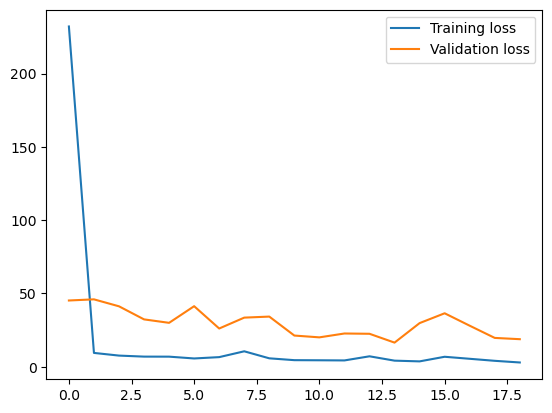

In [21]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend();

#### Prediction

In [22]:
y_pred = model3.predict(X_test)

2024-09-12 21:57:38.942396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:57:38.942663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 0s 18ms/step


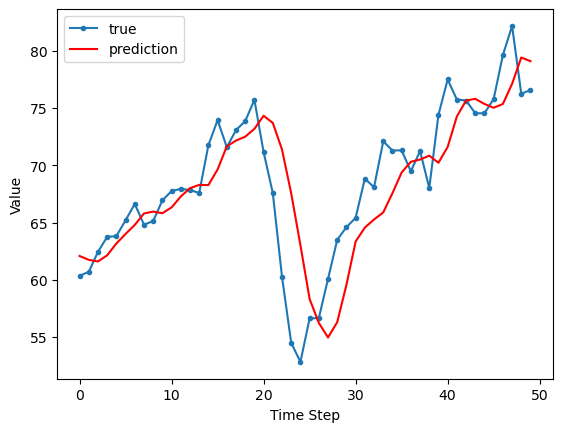

In [23]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [24]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {np.round(r2,2)}')

R-squared: 0.62


#### 4. Fine tuned model with bidirectional LSTM 

In [25]:
# Define model
model4 = keras.Sequential()

# First LSTM layer with return_sequences for stacking
model4.add(keras.layers.LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Second LSTM layer
model4.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, activation='relu')))

# Output layer
model4.add(keras.layers.Dense(units=1))

# Compile the model with a lower learning rate and L2 regularization
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='mean_squared_error', optimizer=optimizer)

# Early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100


2024-09-12 21:57:39.723685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [229]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:57:39.723967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [229]
	 [[{{node Placeholder/_11}}]]


15/15 [==============================] - ETA: 0s - loss: 356.2414

2024-09-12 21:57:43.512993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [50]
	 [[{{node Placeholder/_11}}]]
2024-09-12 21:57:43.517230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [50]
	 [[{{node Placeholder/_11}}]]


15/15 [==============================] - 4s 92ms/step - loss: 356.2414 - val_loss: 41.5347 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 4.9836 - val_loss: 32.4865 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 1s 60ms/step - loss: 5.4492 - val_loss: 39.5281 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 1s 64ms/step - loss: 3.8630 - val_loss: 57.2617 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 1s 50ms/step - loss: 4.1049 - val_loss: 31.0162 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 1s 55ms/step - loss: 3.3279 - val_loss: 13.8603 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 1s 53ms/step - loss: 3.3989 - val_loss: 13.1455 - lr: 0.0010
Epoch 8/100
15/15 [==============================] - 1s 62ms/step - loss: 7.9451 - val_loss: 20.2268 - lr: 0.0010
Epoch 9/100
15/15 [==============================] - 1s 54ms/step - loss: 3.8167 - val_loss: 26.54

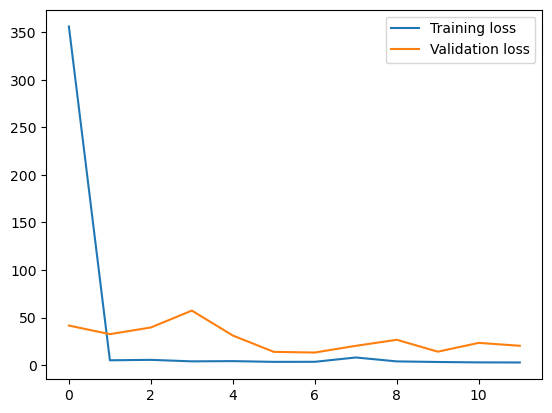

In [26]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend();

#### Prediction 

In [27]:
y_pred = model4.predict(X_test)

2024-09-12 21:57:54.065241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]
2024-09-12 21:57:54.065494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [50,10,1]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 0s 15ms/step


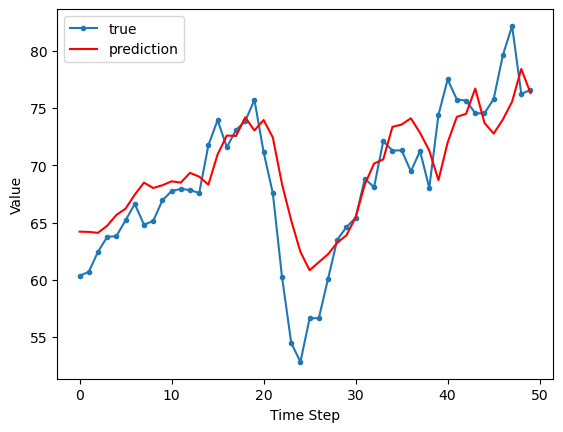

In [28]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [29]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {np.round(r2,2)}')

R-squared: 0.69
